**To-do list**

* Implement return of noise level.
* Implement usage of structural constraint in GP CaKe.
* Run some simulations to test efficacy of EB method for parameter selection.
* Add diagnostic tools.
* Add method for setting last parameters (i.e. temporal localization).
* Add univariate approach for large networks.
* Make transposition of adj_mat, ground_truth and structural_constraint consistent. Currently the latter is transposed with respect to the others. Adj_mat and ground_truth are consistent with matrix notation of an adjacency matrix and the utility.plot_connectivity(), but this can of course be changed. If the structural constraint must be transposed, is the utility.nested_map() correctly implemented?

In [83]:
%matplotlib inline
import numpy as np
import importlib as imp
#from importlib import reload # for python 3

"""
Simulation and GP-CaKe packages.
"""

import simulator as sim
import gpcake
import utility
import matplotlib.pyplot as plt
import diagnostics

In [301]:
p                       = 3
adj_mat                 = np.zeros((p,p))
adj_mat[0,1]            = 1
adj_mat[0,2]            = 1
connection_strength     = 5.0
time_step               = 0.01
time_period             = 4.
time_range              = np.arange(-time_period / 2, time_period / 2, time_step)
n                       = int(time_period / time_step)
simulation_params       = {'network'                : adj_mat,
                           'connection_strength'    : connection_strength,
                           'time_step'              : time_step,
                           'time_period'            : time_period}

ntrials_train                                       = 200
ntrials_test                                        = 200
simulation                                          = sim.integroDifferential_simulator()
simulation.dynamic_parameters["connectivity_relaxations_constants"] = [[0.0,8.0],[8.0,0.0]]
connectivity_relaxation = 10.
(training_samples, testing_samples, ground_truth)   = simulation.simulate_network_dynamics(ntrials_train, 
                                                                                           ntrials_test, 
                                                                                           simulation_params,
                                                                                           connectivity_relaxation = connectivity_relaxation)

Plot a few samples to see the generated time series.

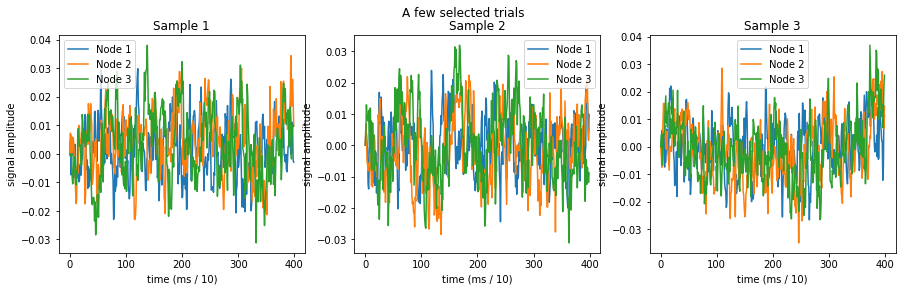

In [302]:
utility.plot_samples(training_samples[0:3])

In [303]:
reload(gpcake)
reload(utility)
reload(diagnostics)
cake = gpcake.gpcake()
cake.initialize_time_parameters(time_step, time_period)
cake.dynamic_parameters["number_sources"] = p
cake.dynamic_type = "Relaxation"

In [304]:
cake.dynamic_parameters = simulation.dynamic_parameters
# This should be replaced by the univariate likelihood maximization for empirical data.

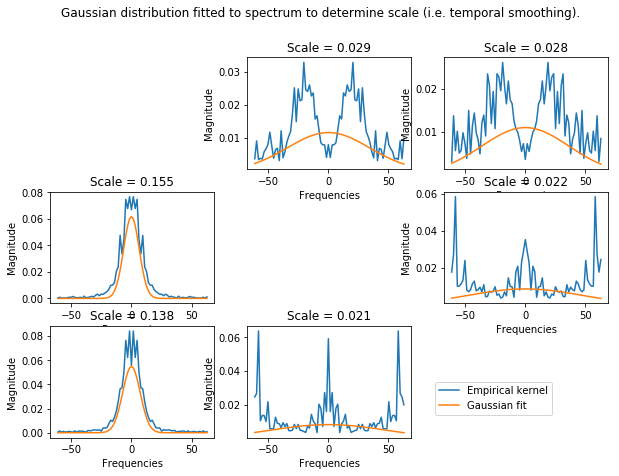

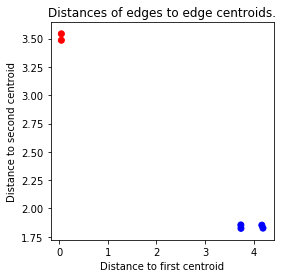

In [305]:
parameter_dict = cake.empirical_bayes_parameter_fit(training_samples, show_diagnostics=True)
# Note: our analysis fails if p=2, which induces symmetric log-likelihood ratios and scales,
# which causes their std to be 0 and hence the normalization throws an error.

# K-means clustering gives a different labeling of the edges than the criteria we specified, since they are different features. 
# Should we not base all on the same?

In [306]:
nu = parameter_dict['time_scale']
G = parameter_dict['structural_connectivity']
sigma = parameter_dict['noise_level']
print nu
print G
print sigma

0.0648674051098
[[0 1 1]
 [1 0 1]
 [1 1 0]]
0.504098757197


Serial implementation.


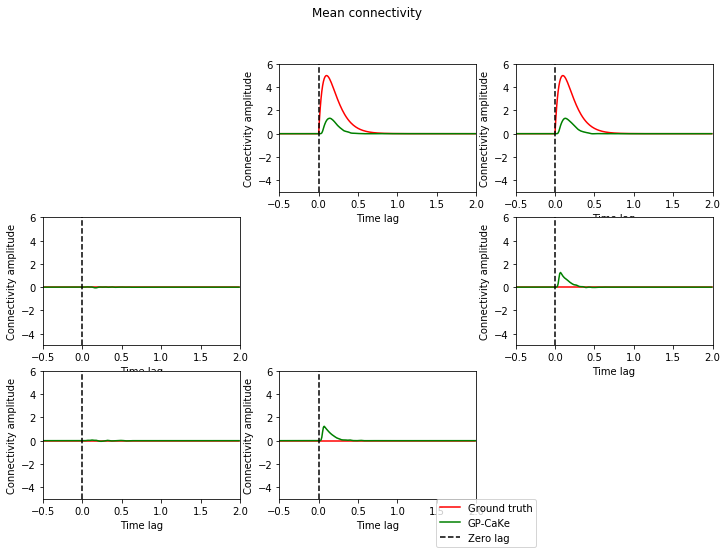

In [307]:

t_s    = 0.05   # temporal offset / time shift
theta  = np.pi  # temporal localization

cake.covariance_parameters = {  "time_scale"        : nu,     # Temporal smoothing
                                "time_shift"        : t_s,     # Temporal offset
                                "causal"            : "yes",    # Hilbert transform
                                "spectral_smoothing": theta }   # Temporal localization
cake.noise_level = sigma

connectivity = cake.run_analysis(testing_samples)
utility.plot_connectivity(ground_truth, connectivity, time_range, t0=-0.5)


In [308]:
mse_scores = utility.estimation_error(ground_truth, connectivity)
print np.mean(mse_scores)

0.264732529741
